In [16]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.auto import tqdm
from PIL import Image
import os
import glob
from torch.utils.data import Dataset,DataLoader


###configs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 5 
BATCH_SIZE = 8 
LR = 1e-4
IMG_SIZE = 256


os.makedirs("results/" ,exist_ok = True)

In [17]:
### define the dataset
class CustomDataset(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)), # 256 256
            # transforms.RandomHorizontalFlip(),
            # transforms.ColorJitter(brightness=0.2, contrast=0.2),
            # transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.images_path)
    
    def __getitem__(self, index):
        image = Image.open(self.images_path[index])
        mask = Image.open(self.masks_path[index]).convert("L")
        mask = mask.point(lambda p: 255 if p>0 else 0)
        
        image = self.transform(image)
        
        mask = self.transform(mask)

        return image, mask

In [18]:
from utils import display_pair 
from unet_model import UNET
from evalution_metrics import DicePlusBCELoss, IOU


In [19]:
def train(model, data_loader, loss_fn, iou_fn, optimizer):
    model.train()

    train_dice = 0
    train_iou = 0
    train_bar = tqdm(data_loader)
    results = {"dice_train":[], "iou_train":[]}

    for batch, (image, mask) in enumerate(train_bar):
        image, mask = image.to(DEVICE), mask.to(DEVICE)
        # image, mask = image.cuda(), mask.cuda()

        pred_mask = model(image)
        mask = mask.float()
        
        dice_loss = loss_fn(pred_mask, mask)
        iou = iou_fn(pred_mask, mask)

        train_dice += dice_loss.item()
        results["dice_train"].append(dice_loss.item())

        train_iou += iou.item()
        results["iou_train"].append(iou.item())

        optimizer.zero_grad()
        dice_loss.backward()
        optimizer.step()
    return (train_dice/len(data_loader), train_iou/len(data_loader),results)

def test(model, data_loader, loss_fn, iou_fn):
    model.eval()

    test_dice = 0
    test_iou = 0    
    results = {"dice_test":[], "iou_test":[]}

    with torch.no_grad():
        for batch, (image, mask) in enumerate(data_loader):
            image, mask = image.to(DEVICE), mask.to(DEVICE)
            # image, mask = image.cuda(), mask.cuda()
            pred_mask = model(image)
            mask = mask.float()

            dice_loss = loss_fn(pred_mask, mask)

            iou = iou_fn(pred_mask, mask)
            
            test_dice += dice_loss.item()
            results["dice_test"].append(dice_loss.item())

            test_iou += iou.item()
            results["iou_test"].append(iou.item())

    return (test_dice/len(data_loader), test_iou/len(data_loader),results)


In [20]:
## defne the datasets

train_img_paths = sorted(glob.glob("../archive/train/image/*"))[0:15000]
train_msk_paths = sorted(glob.glob("../archive/train/mask/*"))[0:15000]

test_img_paths = sorted(glob.glob("../archive/test/image/*"))
test_msk_paths = sorted(glob.glob("../archive/test/mask/*"))

train_dataset = CustomDataset(images_path=train_img_paths, masks_path=train_msk_paths)
test_dataset = CustomDataset(images_path=test_img_paths, masks_path=test_msk_paths)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
def trainer(model, train_loader, test_loader, loss_fn, iou_fn, optimizer):
    results = {
        "train_dice_loss": [],
        "train_iou": [],
        "test_dice_loss" : [],
        "test_iou": [],
    }
    min_loss = None
    for epoch in tqdm(range(EPOCHS)):
        train_dice_loss, train_iou,full_results_train = train(model, train_loader, loss_fn, iou_fn, optimizer)
        test_dice_loss, test_iou,full_results_test = test(model, test_loader, loss_fn, iou_fn)
        print(
            f"Epoch: {epoch+1} | ",
            f"train_loss: {train_dice_loss:.4f} | ",
            f"test_loss: {test_dice_loss:.4f} | ",
            f"train_iou: {train_iou:.4f}|",
            f"test_iou: {test_iou:.4f}|",
        )
        
        torch.save(model, f"results_15000points/model_e{epoch}.pth")
        
        results["train_dice_loss"].append(train_dice_loss)
        results["test_dice_loss"].append(test_dice_loss)
        results["train_iou"].append(train_iou)
        results["test_iou"].append(test_iou)
        
        model.eval()
        test_image, test_mask = test_dataset[np.random.randint(len(test_dataset))]
        with torch.no_grad():
            output = model(test_image.to(DEVICE).unsqueeze(0))

            output = F.sigmoid(output)
            output = (output>0.5).float()
        display_pair(test_mask, output[0].to("cpu"), text=True)
    return results, full_results_train,full_results_test

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1 |  train_loss: 0.7472 |  test_loss: 0.5520 |  train_iou: 0.4576| test_iou: 0.5703|


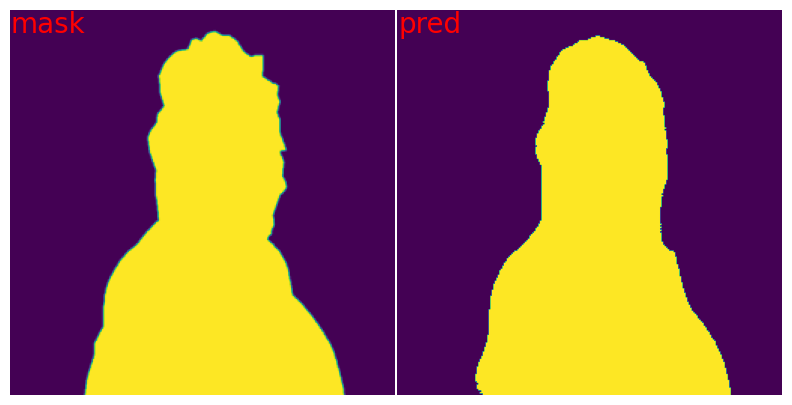

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2 |  train_loss: 0.5429 |  test_loss: 0.4724 |  train_iou: 0.5830| test_iou: 0.6152|


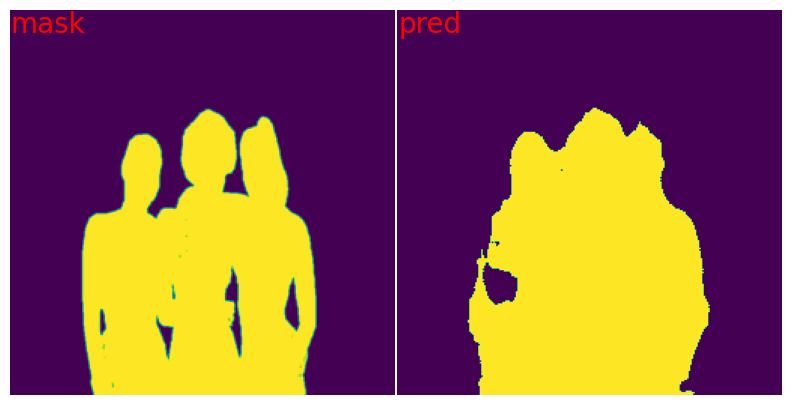

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3 |  train_loss: 0.4506 |  test_loss: 0.3939 |  train_iou: 0.6460| test_iou: 0.6893|


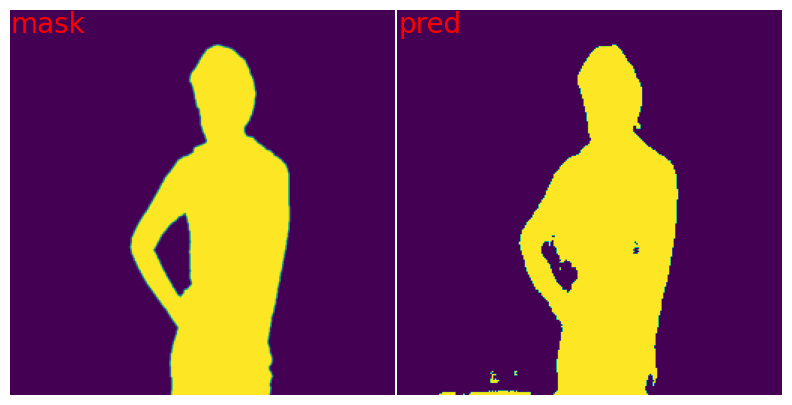

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4 |  train_loss: 0.3848 |  test_loss: 0.3896 |  train_iou: 0.6928| test_iou: 0.7022|


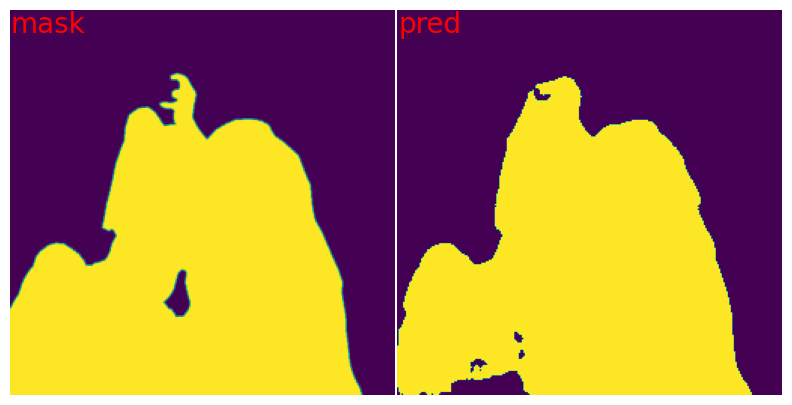

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5 |  train_loss: 0.3331 |  test_loss: 0.3554 |  train_iou: 0.7298| test_iou: 0.7262|


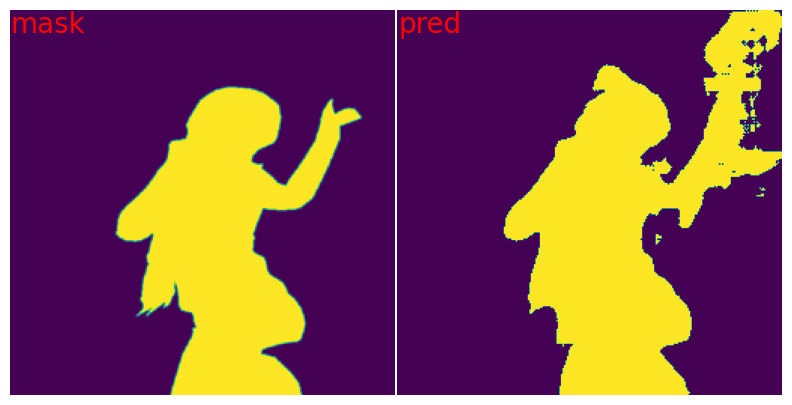

In [23]:

unet_model = UNET(
    in_channels = 3, 
    out_channels = 1, 
).to(DEVICE)
loss_fn = DicePlusBCELoss()
iou_fn = IOU()

optimizer = torch.optim.Adam(unet_model.parameters(), lr=LR)
results_averaged, results_full_train, results_full_test = trainer(unet_model, train_loader, test_loader, loss_fn, iou_fn, optimizer)
